In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import bayes3d.genjax
import genjax
import pathlib

In [147]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=5.0
)

In [139]:
FILTER_SIZE = 3
def compute_score(center_1, center_2, focal_length):
    delta = jnp.array([1.0, 1.0, 0.0])
    dimensions_1 = delta * center_1[2] / focal_length
    dimensions_2 = delta * center_2[2] / focal_length
    bottom_left_1 = center_1 - 0.5* dimensions_1
    top_right_1 =   center_1 + 0.5* dimensions_1
    bottom_left_2 = center_2 - 0.5* dimensions_2
    top_right_2 = center_2 + 0.5* dimensions_2
    logabsdiff = lambda u, v: jnp.log(jnp.abs(u - v))
    x1, y1, z1 = bottom_left_1
    X1, Y1, _ = top_right_1
    x2 , y2, z2 = bottom_left_2
    X2, Y2, _ = top_right_2
    Y1y1, Y2y2, X1x1, X2x2 = logabsdiff(Y1, y1), logabsdiff(Y2, y2), logabsdiff(X1, x1), logabsdiff(X2, x2)
    X1x2, x1x2, X1X2, x1X2 = logabsdiff(X1, x2), logabsdiff(x1, x2), logabsdiff(X1, X2), logabsdiff(x1, X2)
    Y1y2, y1y2, Y1Y2, y1Y2 = logabsdiff(Y1, y2), logabsdiff(y1, y2), logabsdiff(Y1, Y2), logabsdiff(y1, Y2)
    z1z2 = logabsdiff(z1, z2)
    return logsumexp(jnp.array([-jnp.log(12) + Y1y1 + Y2y2 + logsumexp(jnp.array([4*X1x2, 4*x1x2, 4*X1X2, 4*x1X2]), b=jnp.array([1, -1, -1, 1])),
                                -jnp.log(12) + X1x1 + X2x2 + logsumexp(jnp.array([4*Y1y2, 4*y1y2, 4*Y1Y2, 4*y1Y2]), b=jnp.array([1, -1, -1, 1])),
                                X1x1 + X2x2 + Y1y1 + Y2y2 + 2*z1z2]))

@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,2,),
)
def compute_score_vectorize(center_1, center_2, focal_length):
    return compute_score(center_1, center_2, focal_length)

def convolutional_filter(
    ij,
    observed_xyz: jnp.ndarray,
    rendered_xyz_padded: jnp.ndarray,
    focal_length,
):
    p = observed_xyz[ij[0], ij[1], :3]
    filter_latent = jax.lax.dynamic_slice(
        rendered_xyz_padded,
        (ij[0], ij[1], 0),
        (2*FILTER_SIZE + 1, 2*FILTER_SIZE + 1, 3)
    )
    scores = compute_score_vectorize(filter_latent, p, focal_length)
    return scores

@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,2,3,),
)
def convolutional_filter_vectorize(
    ij,
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    focal_length,
):
    rendered_xyz_padded = jax.lax.pad(rendered_xyz,  100.0, ((FILTER_SIZE,FILTER_SIZE,0,),(FILTER_SIZE,FILTER_SIZE,0,),(0,0,0,)))
    scores =  convolutional_filter(ij, observed_xyz, rendered_xyz_padded, focal_length)
    return logsumexp(scores)

def likelihood(observed_xyz, rendered_xyz, focal_length):
    jj, ii = jnp.meshgrid(jnp.arange(observed_xyz.shape[1]), jnp.arange(observed_xyz.shape[0]))
    indices = jnp.stack([ii,jj],axis=-1)

    log_probabilities = convolutional_filter_vectorize(
        indices, observed_xyz,
        rendered_xyz,
        focal_length,
    )
    return log_probabilities

In [140]:
center_1 = jnp.array([1.0, 1.0, 1.0])
center_2 = center_1
print(compute_score(center_1, center_2, 200.0))

center_1 = jnp.array([1.0, 1.0, 1.0])
center_2 = jnp.array([0.1, 0.1, 1.0])
print(compute_score(center_1, center_2, 200.0))

-32.88845
-20.710602


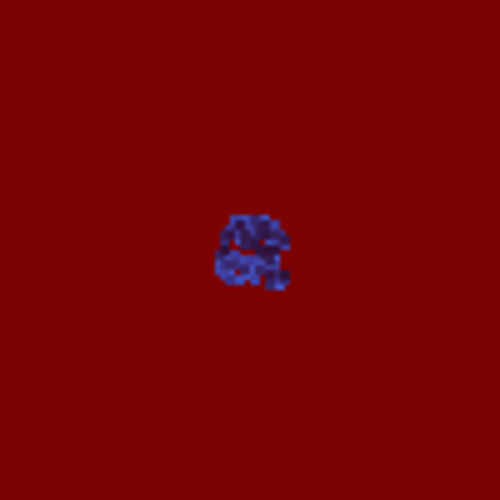

In [176]:
cloud = (jax.random.uniform(jax.random.PRNGKey(10), shape=(100,3)) - 0.5) * 0.2
def render_img(pose):
    img = b.render_point_cloud(b.apply_transform(cloud, pose), intrinsics)
    return b.unproject_depth(img[:,:,2], intrinsics)
pose1 = b.transform_from_pos(jnp.array([0.0, 0.0, 3.0]))
pose2 = b.transform_from_pos(jnp.array([0.0, 10.0, 3.0]))
img1 = render_img(pose1)
img2 = render_img(pose2)
focal_length = intrinsics.fx
b.viz.scale_image(b.get_depth_image(img1[...,2]),5.0)

11.222198 11.222198
1128.5712


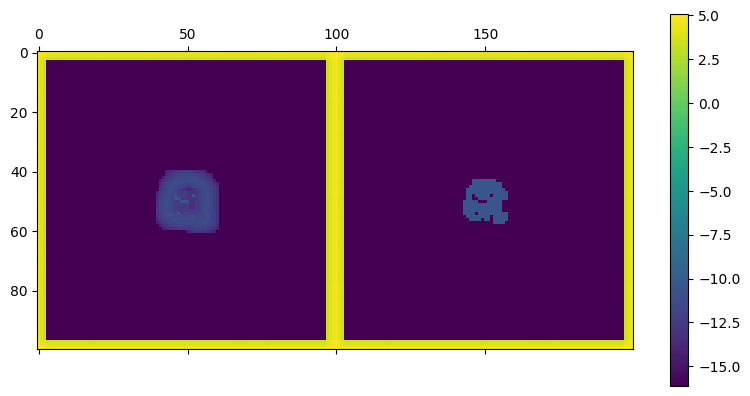

In [177]:
likelihoods1 = likelihood(img1, img1, 200.0) 
likelihoods2 = likelihood(img1, img2, 200.0)
print(logsumexp(likelihoods1), logsumexp(likelihoods2))
diff = likelihoods1 - likelihoods2
print(jnp.abs(diff).sum())
plt.matshow(jnp.hstack([likelihoods1, likelihoods2]))
plt.colorbar()

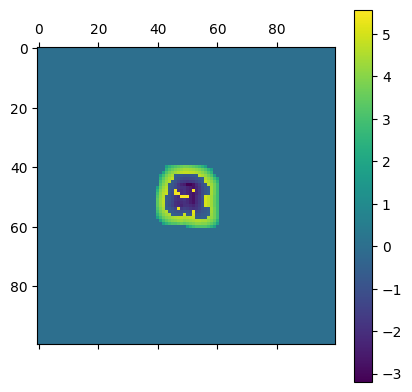

In [178]:
plt.matshow(diff)
plt.colorbar()

In [165]:
compute_score(img1[0,0],img1[0,0],focal_length)

Array(-23.231865, dtype=float32)

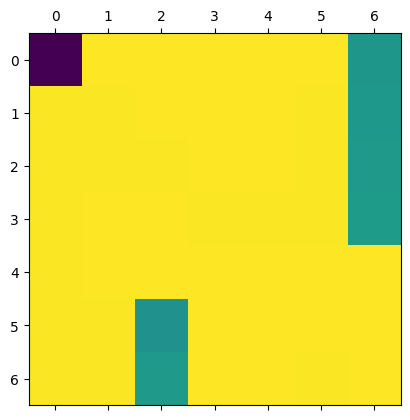

In [166]:
filter = convolutional_filter(jnp.array([50,50]), img1, img1, 200.0)
plt.matshow(filter)

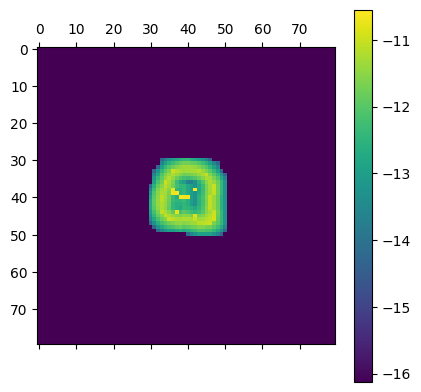

In [167]:
scores = likelihood(img1, img1, 200.0)
plt.matshow(scores[10:-10,10:-10])
plt.colorbar()

In [168]:
print(logsumexp(likelihood(img1, img1, 200.0)))
print(logsumexp(likelihood(img1, img2, 200.0)))

11.222198
11.222198


In [169]:
likelihoods1 = likelihood(img1, img1, 200.0) 
likelihoods2 = likelihood(img1, img2, 200.0)
diff = likelihoods1 - likelihoods2
print(jnp.abs(diff).sum())

1128.5712


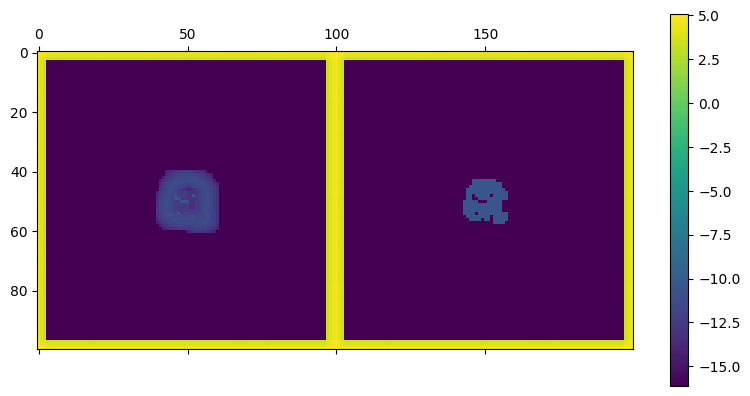

In [170]:
plt.matshow(jnp.hstack([likelihoods1, likelihoods2]))
plt.colorbar()

In [124]:
diff = 0